# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [ ]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

In [ ]:
df = pd.read_csv('/content/bank-additional-full.csv', sep = ';')

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [ ]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [ ]:
# Check for unknowns in each column and calculate the percentage
unknown_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':  # Check only for categorical columns
        unknown_counts[col] = df[col].value_counts().get('unknown', 0)

total_rows = len(df)
unknown_percentages = {col: (count / total_rows) * 100 for col, count in unknown_counts.items()}

# Print the results
for col, percentage in unknown_percentages.items():
    if percentage > 0:
      print(f"Column '{col}': {unknown_counts[col]} unknowns ({percentage:.2f}%)")


Column 'job': 330 unknowns (0.80%)
Column 'marital': 80 unknowns (0.19%)
Column 'education': 1731 unknowns (4.20%)
Column 'default': 8597 unknowns (20.87%)
Column 'housing': 990 unknowns (2.40%)
Column 'loan': 990 unknowns (2.40%)


In [ ]:
# Drop the 'default' column, since it has more then 20% unknown values
df = df.drop('default', axis=1)

# Drop the 'duration' column, based on column description provided above
df = df.drop('duration', axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   housing         41188 non-null  object 
 5   loan            41188 non-null  object 
 6   contact         41188 non-null  object 
 7   month           41188 non-null  object 
 8   day_of_week     41188 non-null  object 
 9   campaign        41188 non-null  int64  
 10  pdays           41188 non-null  int64  
 11  previous        41188 non-null  int64  
 12  poutcome        41188 non-null  object 
 13  emp.var.rate    41188 non-null  float64
 14  cons.price.idx  41188 non-null  float64
 15  cons.conf.idx   41188 non-null  float64
 16  euribor3m       41188 non-null  float64
 17  nr.employed     41188 non-null 

In [7]:
# Drop 'poutcome' and 'contact' columns, since they have almost same values
df = df.drop(['poutcome', 'contact'], axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   housing         41188 non-null  object 
 5   loan            41188 non-null  object 
 6   month           41188 non-null  object 
 7   day_of_week     41188 non-null  object 
 8   campaign        41188 non-null  int64  
 9   pdays           41188 non-null  int64  
 10  previous        41188 non-null  int64  
 11  emp.var.rate    41188 non-null  float64
 12  cons.price.idx  41188 non-null  float64
 13  cons.conf.idx   41188 non-null  float64
 14  euribor3m       41188 non-null  float64
 15  nr.employed     41188 non-null  float64
 16  y               41188 non-null  object 
dtypes: float64(5), int64(4), object

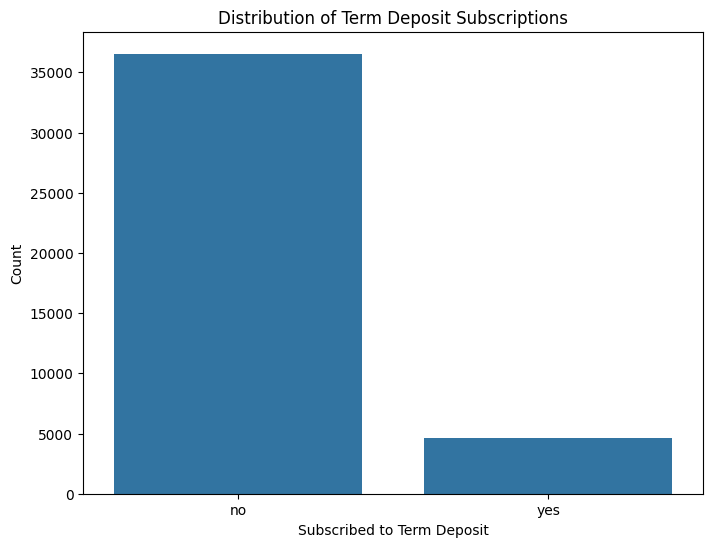

In [8]:
# prompt: create a graph using sns keeping subscribed to term deposit on xlabel and cout on ylabel

plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=df)
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Count')
plt.title('Distribution of Term Deposit Subscriptions')
plt.show()


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Business Objective

To predict whether a customer will subscribe to a term deposit based on various customer demographics, socioeconomic factors, and past campaign interactions, enabling the bank to more effectively target its marketing campaigns and improve conversion rates.


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [13]:
#Selecting features from just the bank information group
features = ['age', 'job', 'marital', 'education', 'housing', 'loan', 'month', 'day_of_week']

numerical_selector = selector(dtype_exclude=object)
categorical_selector = selector(dtype_include=object)

numerical_columns = numerical_selector(df[features])
categorical_columns = categorical_selector(df[features])

# Create the preprocessing pipelines for numerical and categorical features
numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_preprocessor, categorical_columns),
        ('num', numerical_preprocessor, numerical_columns)
    ])

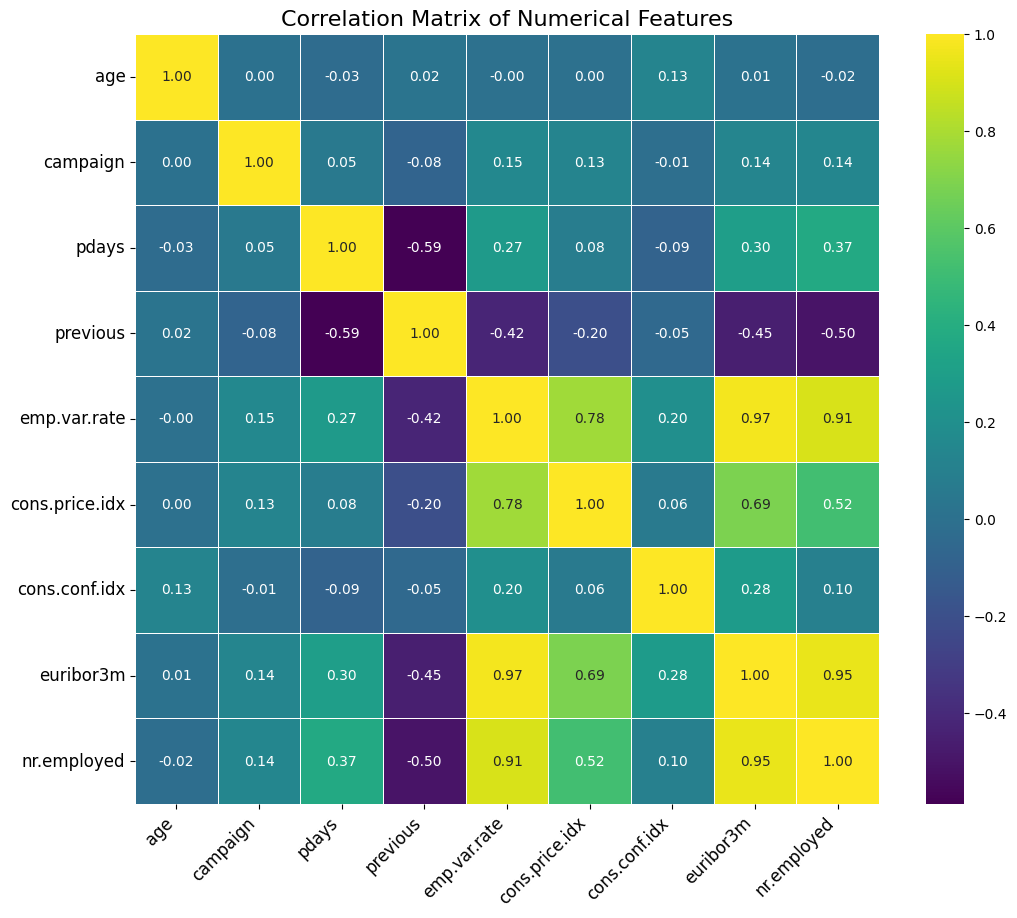

In [19]:
numerical_cols = numerical_selector(df)
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [22]:
#processing the target column ['y']
df['y'] = df['y'].str.strip().map({'yes': 1, 'no': 0})
y = df['y']

AttributeError: Can only use .str accessor with string values!

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [23]:
X = df.drop('y', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for training data
X_train_processed = preprocessor.fit_transform(X_train)
# Preprocessing for testing data
X_test_processed = preprocessor.transform(X_test)

print(X_train_processed.shape)
print(X_test_processed.shape)


(32950, 39)
(8238, 39)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [24]:
# Calculate the percentage of the majority class in the target variable
baseline_accuracy = y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy: {baseline_accuracy:.4f}")


Baseline accuracy: 0.8876


Baseline has to be detrmined to be 88.76%, classifier has to aim to beat this

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [25]:
# Create and train the Logistic Regression model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_model.predict(X_test_processed)



### Problem 9: Score the Model

What is the accuracy of your model?

In [26]:

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")

print(classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.8860
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7303
           1       0.48      0.07      0.12       935

    accuracy                           0.89      8238
   macro avg       0.69      0.53      0.53      8238
weighted avg       0.85      0.89      0.85      8238



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [30]:
import pandas as pd
# Create a list to store model results
results = []

# Define the models
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Loop through the models
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_processed, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test_processed)
    train_accuracy = accuracy_score(y_train, model.predict(X_train_processed))
    test_accuracy = accuracy_score(y_test, y_pred)

    results.append([name, train_time, train_accuracy, test_accuracy])

# Create the DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
results_df


,Model,Train Time,Train Accuracy,Test Accuracy
0,KNN,0.006816,0.901669,0.882617
1,Decision Tree,0.863322,0.969165,0.831270
2,SVM,119.449834,0.893354,0.887109
3,Logistic Regression,0.058515,0.886373,0.886016


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

y             0     1  Total  Subscription Rate
marital                                        
divorced   4136   476   4612           0.103209
married   22396  2532  24928           0.101573
single     9948  1620  11568           0.140041
unknown      68    12     80           0.150000


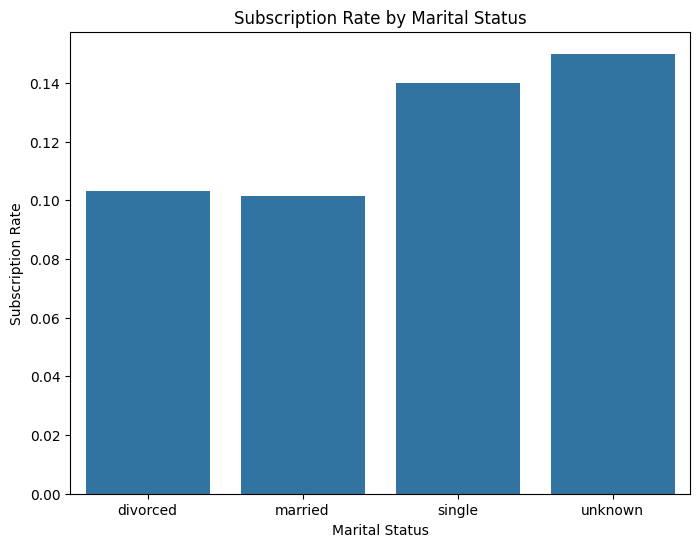

y                 0     1  Total  Subscription Rate
job                                                
admin.         9070  1352  10422           0.129726
blue-collar    8616   638   9254           0.068943
entrepreneur   1332   124   1456           0.085165
housemaid       954   106   1060           0.100000
management     2596   328   2924           0.112175
retired        1286   434   1720           0.252326
self-employed  1272   149   1421           0.104856
services       3646   323   3969           0.081381
student         600   275    875           0.314286
technician     6013   730   6743           0.108260
unemployed      870   144   1014           0.142012
unknown         293    37    330           0.112121


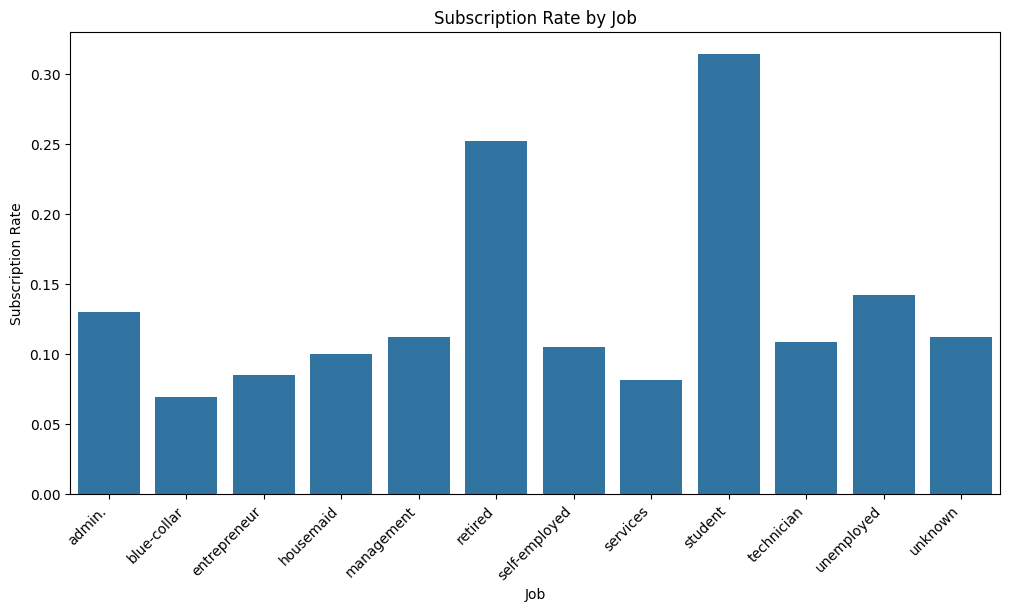

y                        0     1  Total  Subscription Rate
education                                                 
basic.4y              3748   428   4176           0.102490
basic.6y              2104   188   2292           0.082024
basic.9y              5572   473   6045           0.078246
high.school           8484  1031   9515           0.108355
illiterate              14     4     18           0.222222
professional.course   4648   595   5243           0.113485
university.degree    10498  1670  12168           0.137245
unknown               1480   251   1731           0.145003


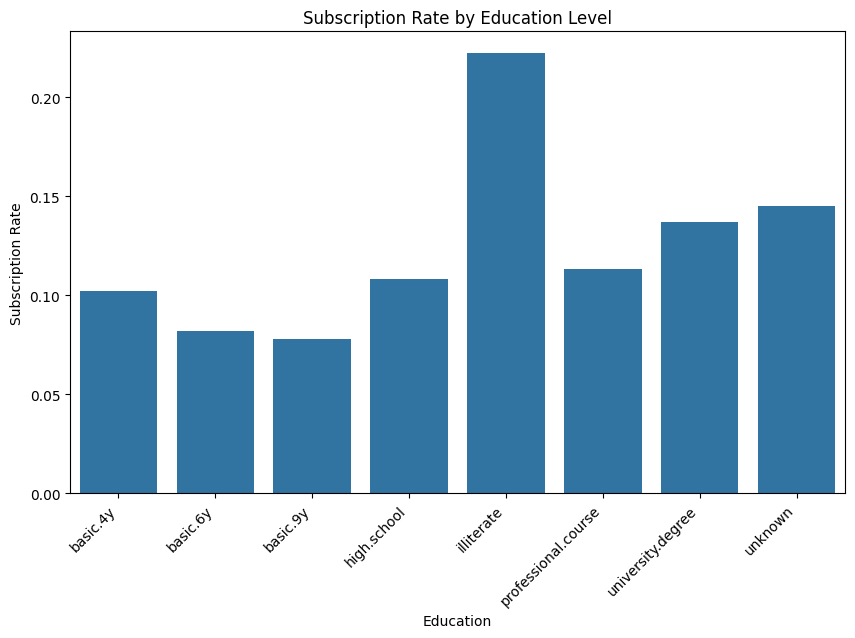

In [31]:
# Analyze the 'marital' column's impact on the target variable 'y'
marital_counts = df.groupby(['marital', 'y']).size().unstack(fill_value=0)
marital_counts['Total'] = marital_counts.sum(axis=1)
marital_counts['Subscription Rate'] = marital_counts[1] / marital_counts['Total']
print(marital_counts)

# Visualize the subscription rates for different marital statuses
plt.figure(figsize=(8, 6))
sns.barplot(x=marital_counts.index, y=marital_counts['Subscription Rate'])
plt.xlabel('Marital Status')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Marital Status')
plt.show()

# Analyze the 'job' column
job_counts = df.groupby(['job', 'y']).size().unstack(fill_value=0)
job_counts['Total'] = job_counts.sum(axis=1)
job_counts['Subscription Rate'] = job_counts[1] / job_counts['Total']
print(job_counts)

# Visualize subscription rate by job
plt.figure(figsize=(12, 6))
sns.barplot(x=job_counts.index, y=job_counts['Subscription Rate'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Job')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Job')
plt.show()

# Analyze the 'education' column
education_counts = df.groupby(['education', 'y']).size().unstack(fill_value=0)
education_counts['Total'] = education_counts.sum(axis=1)
education_counts['Subscription Rate'] = education_counts[1] / education_counts['Total']
print(education_counts)

# Visualize subscription rate by education level
plt.figure(figsize=(10,6))
sns.barplot(x=education_counts.index, y=education_counts['Subscription Rate'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Education')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Education Level')
plt.show()


In [32]:
# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create the KNN model
knn_model = KNeighborsClassifier()

# Perform GridSearchCV
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train_processed, y_train)

# Print the best hyperparameters and accuracy
print("Best hyperparameters for KNN:", grid_search_knn.best_params_)
print("Best accuracy for KNN:", grid_search_knn.best_score_)

# Evaluate the best model on the test set
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test_processed)
test_accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Test accuracy for best KNN model:", test_accuracy_knn)


Best hyperparameters for KNN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Best accuracy for KNN: 0.8858270106221549
Test accuracy for best KNN model: 0.8861374119932023


In [33]:
# Define the parameter grid for Decision Tree
param_grid_2 = {
    'max_depth': [3, 5, 10, 15, 20, None],  # Added None for unlimited depth
    'min_samples_split': [2, 5, 10, 15], # Added more options for min samples split
    'min_samples_leaf': [1, 2, 4], # Added min samples leaf
    'criterion': ['gini', 'entropy', 'log_loss'] # Added different splitting criteria
}

# Create the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42) # added random state for reproducibility

# Perform GridSearchCV with more scoring options
grid_dt = GridSearchCV(dt_model, param_grid_2, cv=5, scoring=['accuracy', 'roc_auc'], refit='accuracy') # Added multiple scoring metrics and refit based on accuracy
grid_dt.fit(X_train_processed, y_train) # use the processed training data

# Print the best hyperparameters and scores
print("Best params for DT:", grid_dt.best_params_)
print("Best accuracy score for DT:", grid_dt.best_score_) # print the best accuracy score
print("Best estimator for DT:", grid_dt.best_estimator_) # print the best estimator


# Predict on the test set using the best estimator
y_pred_dt = grid_dt.predict(X_test_processed)

# Evaluate the best model
print(classification_report(y_test, y_pred_dt))
print(f"Decision Tree Test Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Decision Tree ROC AUC Score: {roc_auc_score(y_test, y_pred_dt)}")


Best params for DT: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy score for DT: 0.8877996965098633
Best estimator for DT: DecisionTreeClassifier(max_depth=5, random_state=42)
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7303
           1       0.50      0.06      0.11       935

    accuracy                           0.89      8238
   macro avg       0.70      0.53      0.52      8238
weighted avg       0.85      0.89      0.85      8238

Decision Tree Test Accuracy: 0.8865015780529255
Decision Tree ROC AUC Score: 0.5265787776029337


In [37]:
#KNN
print(classification_report(y_test, y_pred_knn))
print(f"KNN ROC AUC Score: {roc_auc_score(y_test, y_pred_knn)}")


              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7303
           1       0.49      0.08      0.14       935

    accuracy                           0.89      8238
   macro avg       0.69      0.53      0.54      8238
weighted avg       0.85      0.89      0.85      8238

KNN ROC AUC Score: 0.5343003864062896


In [38]:
#Decision Tree
print(classification_report(y_test, y_pred_dt))
print(f"Decision Tree ROC AUC Score: {roc_auc_score(y_test, y_pred_dt)}")


              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7303
           1       0.50      0.06      0.11       935

    accuracy                           0.89      8238
   macro avg       0.70      0.53      0.52      8238
weighted avg       0.85      0.89      0.85      8238

Decision Tree ROC AUC Score: 0.5265787776029337


##### Questions